In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import GaussianBinaryMask
import numpy as np
import matplotlib.pyplot as plt
from mcmc import DiscreteMetropolisHastings
from utils import index_to_binary_mask_loglikelihood_fn, uniform_backwards_prob, trajectory_loglikelihood_reward_fn, l1_distance
from gfn import BinaryMaskGFN, modified_trajectory_balance_loss
import torch

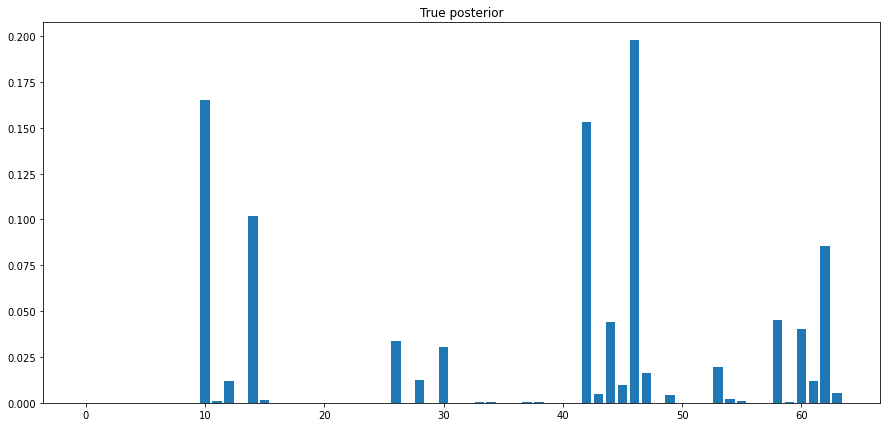

In [24]:
d = 3
n = 2
m = n * d
N = 10
data_maker = GaussianBinaryMask(d, n)
X = data_maker.sample(N)
posterior = data_maker.evaluate_true_posterior(X)

plt.figure(figsize=(15, 7))
plt.bar(range(2 ** m), posterior)
plt.title('True posterior')
plt.show()

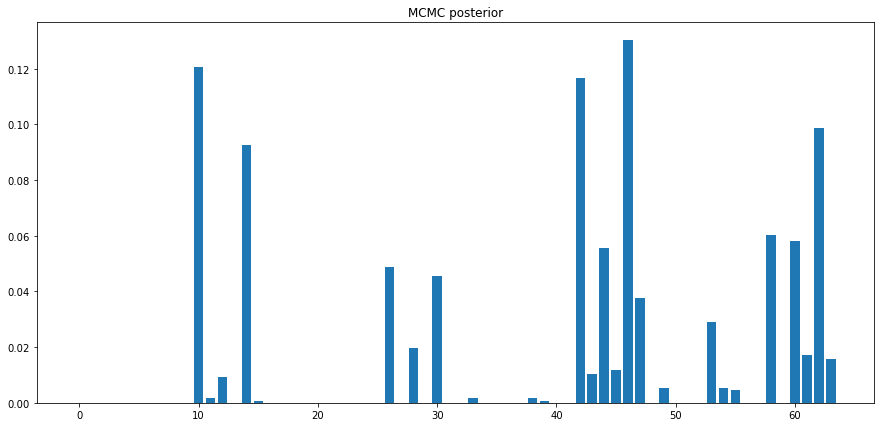

In [25]:
mh = DiscreteMetropolisHastings(K=2**m, loglikelihood_fn=index_to_binary_mask_loglikelihood_fn(data_maker))
mcmc_index_init = np.random.randint(2**m)
mcmc_iterations = 10000
mcmc_posterior = mh.approximate_posterior(mcmc_index_init, mcmc_iterations)

plt.figure(figsize=(15, 7))
plt.bar(range(2 ** m), mcmc_posterior)
plt.title('MCMC posterior')
plt.show()

In [26]:
gf = BinaryMaskGFN(m=m, h=64)

In [27]:
lr = 3e-4
iterations = 10000
optimizer = torch.optim.Adam(gf.parameters(), lr=lr)
losses = []
traj_lengths = []
temperature = 1.
terminate_prob_sampling = 0.1
all_rewards = set()
min_rew = -1e4
for i in range(iterations):
    if i < 100:
        temp = 5.
    elif i < 1000:
        temp = 2.
    else:
        temp = temperature
    traj = gf.on_policy_trajectory_sample(temp)
    # traj = gf.uniform_trajectory_sample(terminate_prob_sampling)
    length = traj.shape[0]
    if length == 1:
        continue
    
    loss, rewards, _ = modified_trajectory_balance_loss(gf, traj, MIN_REW=min_rew, pb_fn=uniform_backwards_prob,
                                            reward_fn=trajectory_loglikelihood_reward_fn(data_maker))
    all_rewards.update(rewards)
    new_min_rew = max(all_rewards) - 15  # (exp(-5) = 0.006)
    min_rew = max(min_rew, new_min_rew) 
    # loss = trajectory_balance_loss(traj)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    traj_lengths.append(length)
    losses.append(loss.item())
    if i % 500 == 0:
        print(loss.item())


3.2079367637634277
13.807973861694336
54.13896942138672
4.852391242980957
9.302006721496582
0.04875131696462631
0.6827365159988403
0.4349307715892792
0.46195295453071594
0.02721288427710533
2.8114001750946045
0.04481727257370949
0.08895549178123474
0.03963645547628403
0.03214215859770775
0.03823839873075485
0.11973947286605835
0.05344323068857193
0.005550897680222988
0.011952879838645458


In [28]:
min_rew

-80.8983858525653

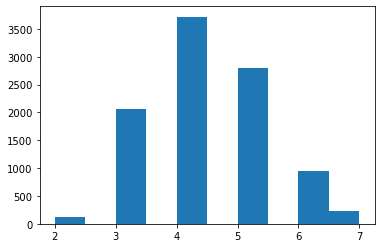

In [29]:
plt.hist(traj_lengths)
plt.show()

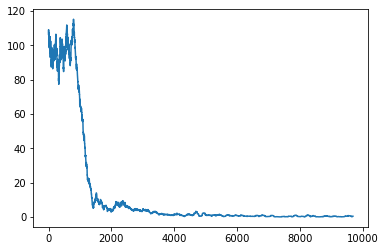

In [30]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(losses[100:], 100))


In [31]:
gfn_samples = [(gf.on_policy_trajectory_sample(temperature=1.)[-1, :].detach().numpy() * (2 ** np.arange(m-1, -1, -1))).sum() for _ in range(1000)]
gfn_posterior = [list(gfn_samples).count(i) / len(gfn_samples) for i in range(2 ** m)]

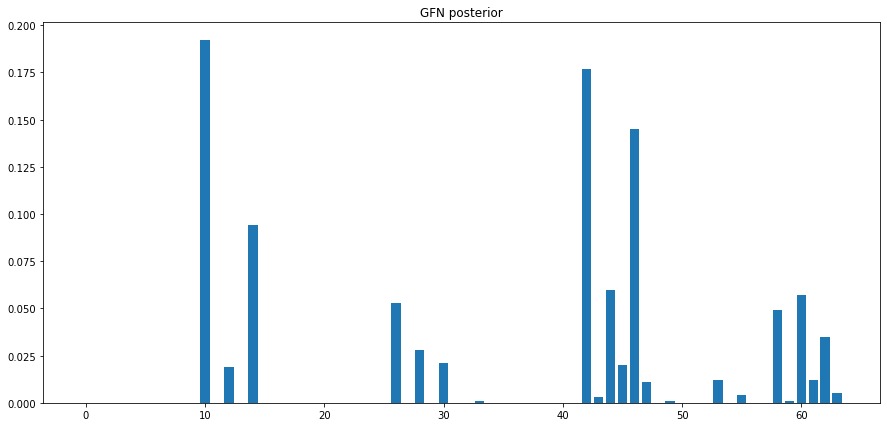

In [32]:
plt.figure(figsize=(15, 7))
plt.bar(range(2 ** m), gfn_posterior)
plt.title('GFN posterior')
plt.show()

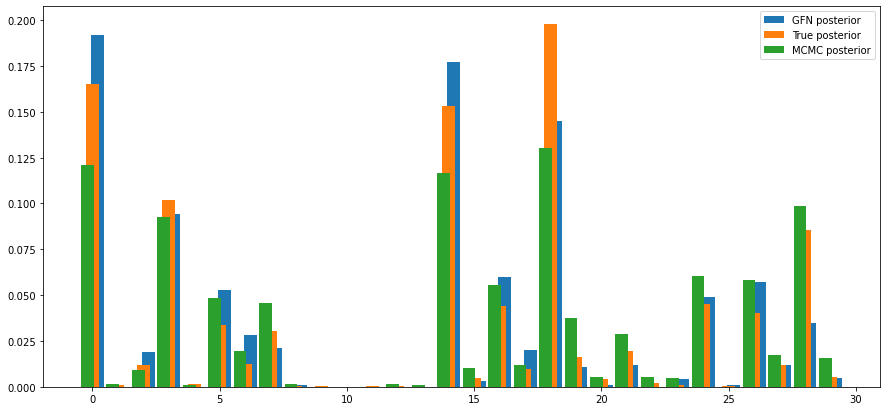

In [33]:
plt.figure(figsize=(15, 7))
ax = plt.subplot(111)
w = 0.5
ds = 0.2
idxs = np.array([i for i, j in enumerate(posterior) if j > 1e-4])
# ax.bar(np.arange(2 ** m)+ds, gfn_posterior, width=w, label='GFN posterior')
# ax.bar(np.arange(2 ** m), posterior, width=w, label='True posterior')
# ax.bar(np.arange(2 ** m)-ds, mcmc_posterior, width=w, label='MCMC posterior')
ax.bar(np.arange(len(idxs)) + ds, np.array(gfn_posterior)[idxs], width=w, label='GFN posterior')
ax.bar(np.arange(len(idxs)) , np.array(posterior)[idxs], width=w, label='True posterior')
ax.bar(np.arange(len(idxs)) - ds, np.array(mcmc_posterior)[idxs], width=w, label='MCMC posterior')
ax.legend()
plt.show()

In [34]:
print(l1_distance(gfn_posterior, posterior))
print(l1_distance(mcmc_posterior, posterior))

0.2887245818938903
0.3233193710222898
